In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, AberratedLensKrivanek
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.aberrations import W_krivanek, KrivanekCoeffs
from temgym_core.utils import fibonacci_spiral
from temgym_core.run import run_to_end

import numpy as np
import abtem

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

jax.config.update("jax_enable_x64", True)

In [2]:
scale = 1  # scale to microns

aperture_window_width = 5000e-9
num_aper_pixels = 256
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 2000e-9

num_beams = int(1e5)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-10
k = 2 * np.pi / wavelength
wo = 1e-8

aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

In [3]:
# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [4]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [5]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)

Text(0.5, 1.0, 'Gauss Phase at input plane')

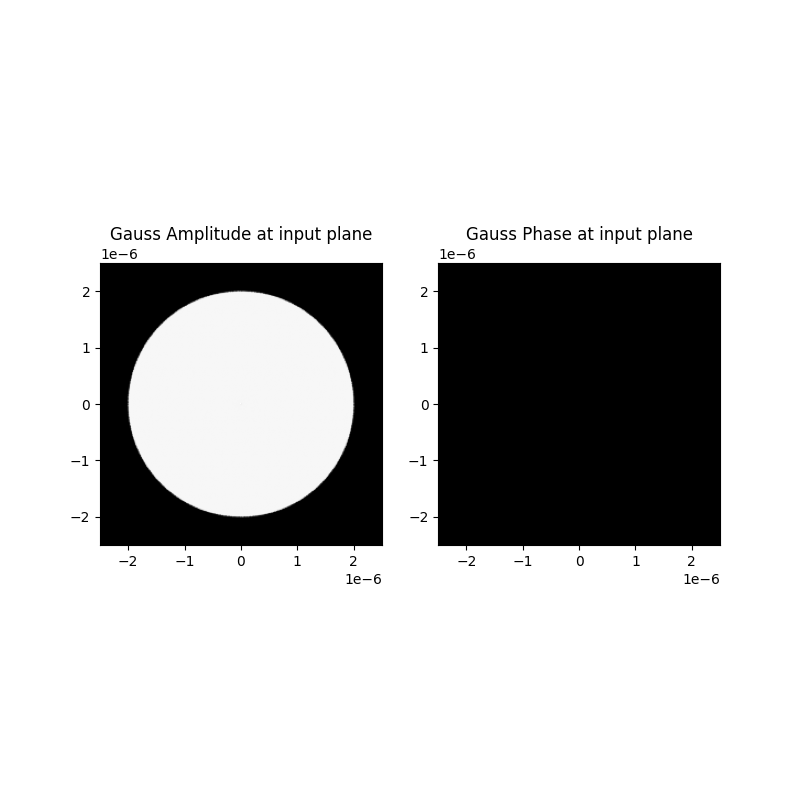

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Amplitude at input plane
ax[0].imshow(jnp.abs(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[0].set_title('Gauss Amplitude at input plane')

# Phase at input plane
ax[1].imshow(jnp.angle(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[1].set_title('Gauss Phase at input plane')

In [7]:
F1 = 2.5e-3
defocus = 1e-11
pixel_size_bfp = wavelength * abs(F1) / (aperture_window_width)
coeffs = KrivanekCoeffs(C30=0.0, C21=0.0, C12=0.0, C23=0.0, C32=0.0)
parallel_beam = ParallelBeam(z=0.0, radius=aperture_radius)
lens = Lens(focal_length=F1, z=0.0)
detector = Detector(z=defocus, pixel_size=(aperture_pixel_size[0], aperture_pixel_size[1]), shape=(num_aper_pixels, num_aper_pixels))
detector_xy = detector.coords_1d
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

print(extent_x, extent_y)
model = [
    parallel_beam,
    lens,
    detector,
]

input_rays = rays.derive(z=jnp.zeros(num_beams))
det_image_at_lens = make_gaussian_image(input_rays, model, batch_size=100)

(Array(-2.49023438e-06, dtype=float64), Array(2.49023438e-06, dtype=float64)) (Array(2.49023438e-06, dtype=float64), Array(-2.49023438e-06, dtype=float64))


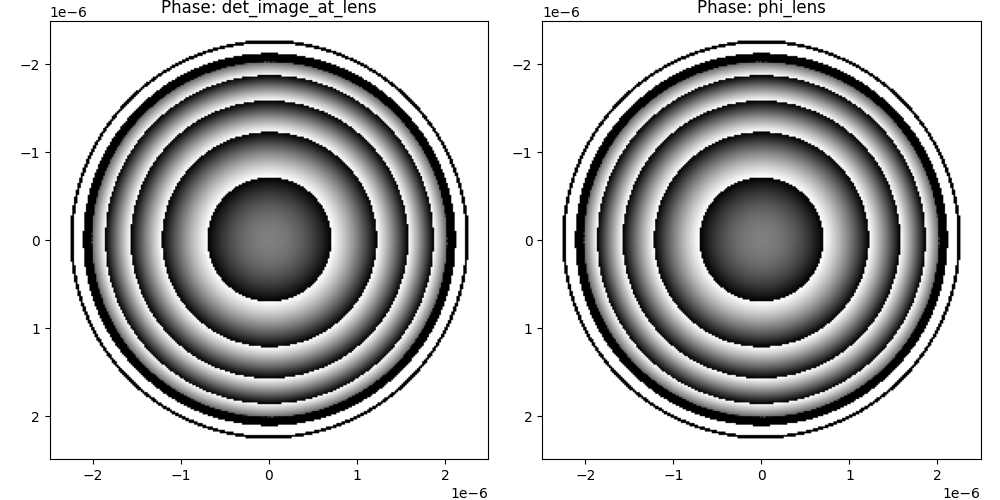

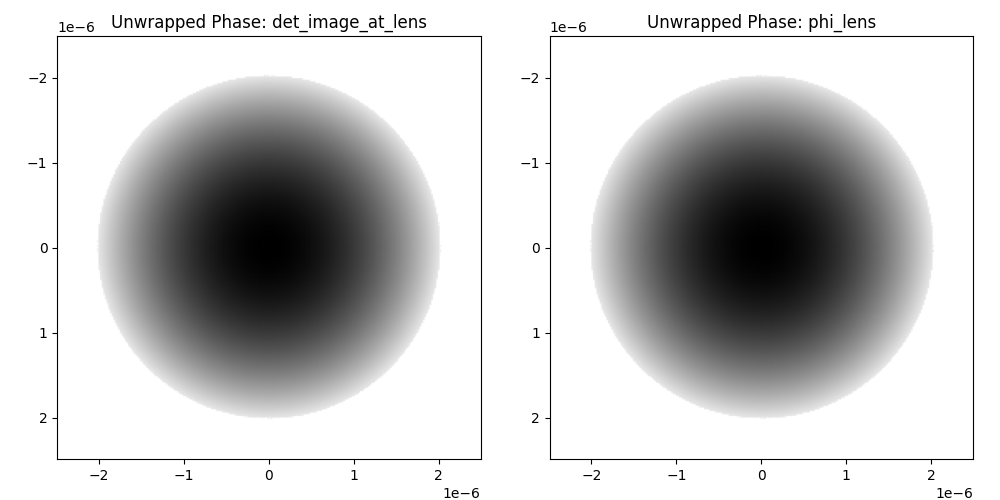

In [8]:
detector_coords = detector.coords
X, Y = detector_coords[:, 0], detector_coords[:, 1]
X = X.reshape((num_aper_pixels, num_aper_pixels))
Y = Y.reshape((num_aper_pixels, num_aper_pixels))   

phi_lens = np.exp(1j * (k * (-1/F1) / 2.0) * (X**2 + Y**2))

phi_lens = phi_lens * np.abs(aperture_image)

# Zero the phase by subtracting the phase at the center pixel
center_idx = num_aper_pixels // 2
det_image_at_lens += np.angle(det_image_at_lens[center_idx, center_idx])
phi_lens += np.angle(phi_lens[center_idx, center_idx])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(jnp.angle(det_image_at_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Phase: det_image_at_lens')
im1 = axs[1].imshow(np.angle(phi_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Phase: phi_lens')
plt.tight_layout()

# Unwrap the phase of both images
unwrapped_det_image_at_lens = np.abs(unwrap_phase(np.angle(det_image_at_lens)))
unwrapped_phi_lens = np.abs(unwrap_phase(np.angle(phi_lens)))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(unwrapped_det_image_at_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Unwrapped Phase: det_image_at_lens')
im1 = axs[1].imshow(unwrapped_phi_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Unwrapped Phase: phi_lens')
plt.tight_layout()